In [5]:
import os
import cv2
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [6]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [7]:
class LimitValidationAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', threshold=0.93):
        super(LimitValidationAccuracy, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get(self.monitor)
        if current_val_accuracy is not None and current_val_accuracy > self.threshold:
            print(f"\nValidation accuracy reached {current_val_accuracy:.4f} > {self.threshold:.4f}. Stopping training.")
            self.model.stop_training = True

In [8]:
files = [
    'apple - edible', 'apple - inedible', 'banana - edible', 'banana - inedible',
    'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible',
    'donut - edible', 'donut - inedible', 'edible', 'egg - edible', 'egg - inedible',
    'mango - edible', 'mango - inedible', 'pizza - edible', 'pizza - inedible', 
    'rice - edible', 'rice - inedible'
]


file_path = "/kaggle/input/foodition-dataset/dataset/{}"
data = {}

for f in files:
    data[f] = []

for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg') or i.endswith('.png') or i.endswith('.jpeg'):
            data[col].append(i)


In [9]:
data_count = {key: len(value) for key, value in data.items()}
total_data_count = sum(data_count.values())
print(data_count)


{'apple - edible': 505, 'apple - inedible': 538, 'banana - edible': 513, 'banana - inedible': 600, 'bread - edible': 742, 'bread - inedible': 482, 'chicken - edible': 531, 'chicken - inedible': 540, 'donut - edible': 708, 'donut - inedible': 526, 'edible': 540, 'egg - edible': 486, 'egg - inedible': 484, 'mango - edible': 542, 'mango - inedible': 544, 'pizza - edible': 426, 'pizza - inedible': 560, 'rice - edible': 593, 'rice - inedible': 558}


In [10]:
sample_size = total_data_count
width = 160
height = 160

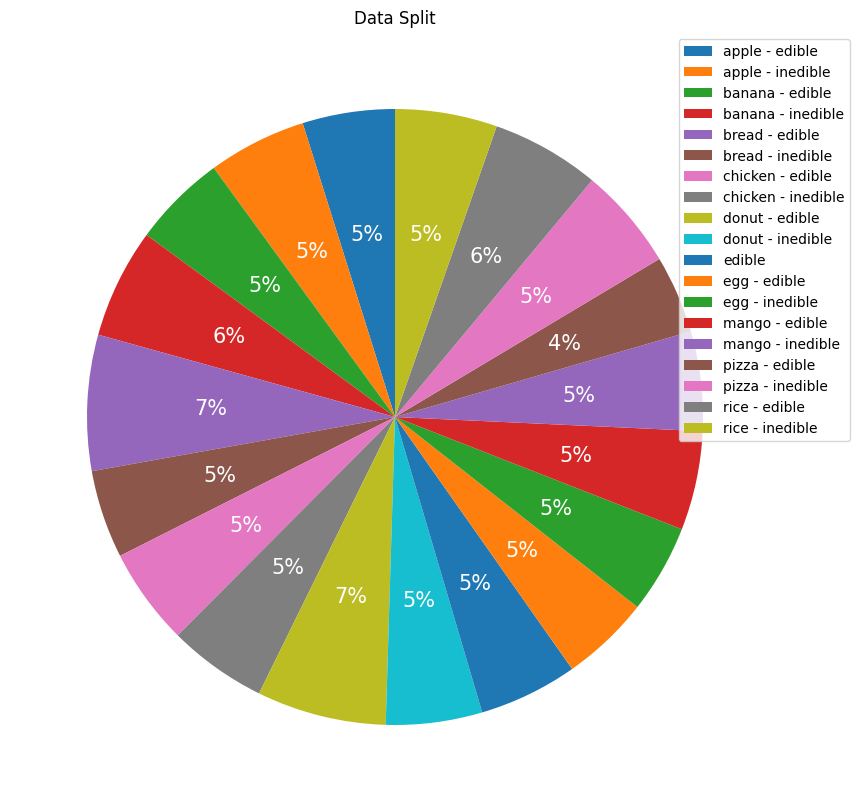

In [11]:
sizes = [len(data[f]) for f in files]

plt.figure(figsize=(10, 10), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [12]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class rice - inedible
Calculate Time 135.92739


In [13]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(10418, 160, 160, 3)

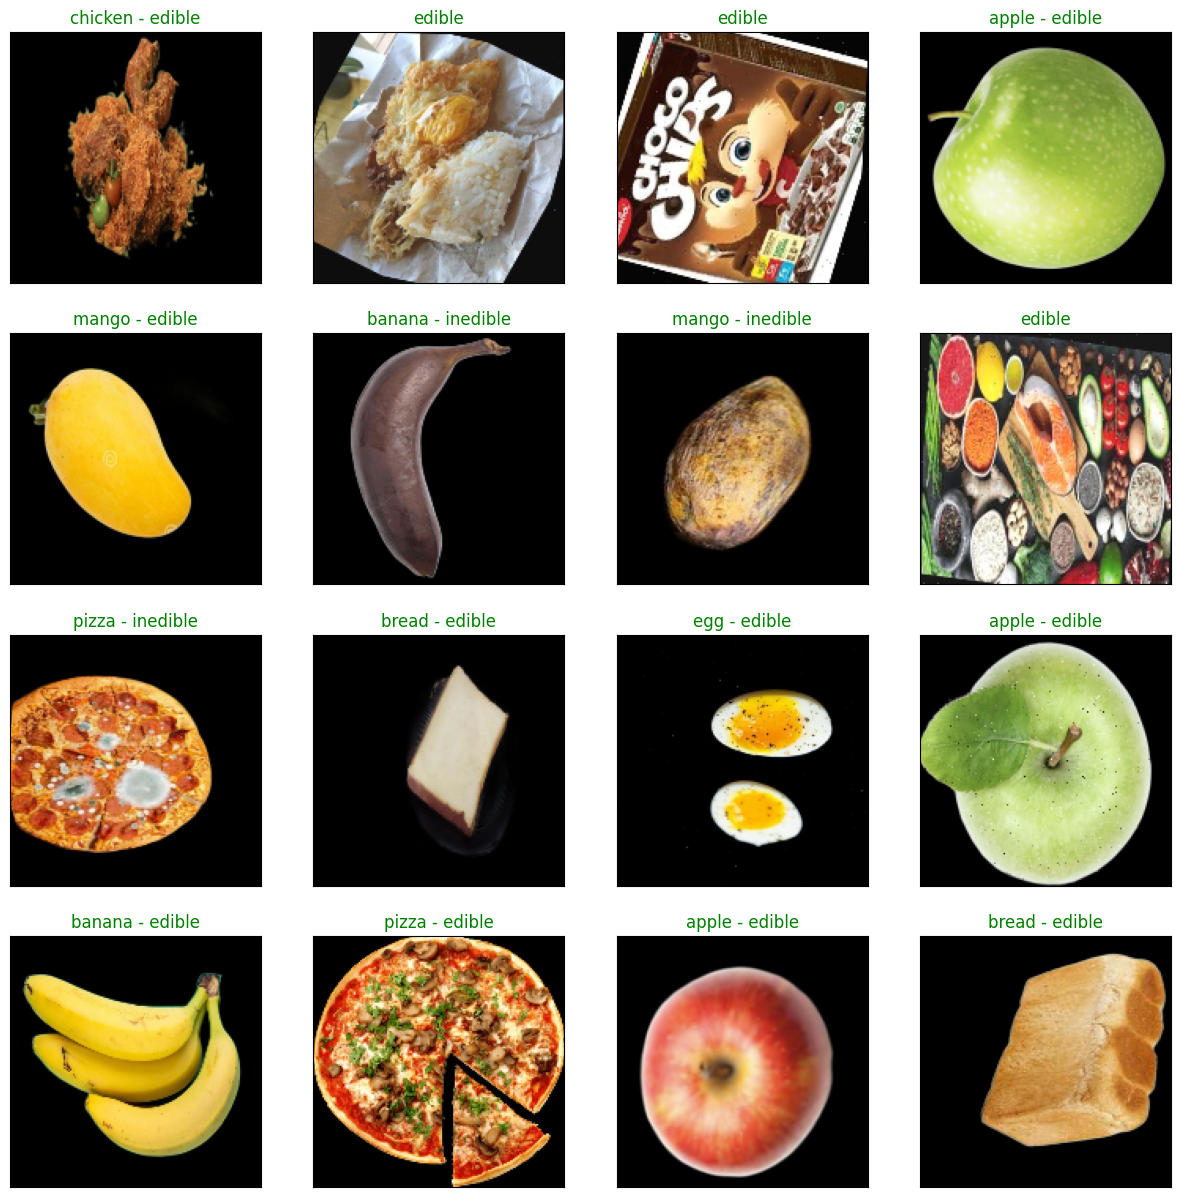

In [14]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if 'edible' in image_target[fig]:
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [16]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [18]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    
    fine_tune_at = 100

    
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.7),
        layers.Dense(19, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def lr_scheduler(epoch):
        return 0.001 * np.exp(-0.1 * epoch)
    
    limit_val_acc_callback = LimitValidationAccuracy(monitor='val_accuracy', threshold=0.94)
    
#     callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                                 patience=2,
#                                                 restore_best_weights=True)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

    history = model.fit(train_images, train_labels, epochs=15, validation_data=(test_images, test_labels), callbacks=[lr_callback, limit_val_acc_callback])

Epoch 1/15
228/228 [==============================] - 42s 74ms/step - loss: 1.0162 - accuracy: 0.7983 - val_loss: 9.8810 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 2/15
228/228 [==============================] - 10s 42ms/step - loss: 0.4615 - accuracy: 0.9264 - val_loss: 7.8910 - val_accuracy: 0.2732 - lr: 9.0484e-04
Epoch 3/15
228/228 [==============================] - 10s 43ms/step - loss: 0.2766 - accuracy: 0.9627 - val_loss: 5.8447 - val_accuracy: 0.3145 - lr: 8.1873e-04
Epoch 4/15
228/228 [==============================] - 10s 42ms/step - loss: 0.1932 - accuracy: 0.9786 - val_loss: 1.5380 - val_accuracy: 0.7326 - lr: 7.4082e-04
Epoch 5/15
228/228 [==============================] - 10s 42ms/step - loss: 0.1402 - accuracy: 0.9857 - val_loss: 0.9630 - val_accuracy: 0.7850 - lr: 6.7032e-04
Epoch 6/15
227/228 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9902
Validation accuracy reached 0.9405 > 0.9400. Stopping training.
228/228 [==============================

98/98 - 2s - loss: 0.2923 - accuracy: 0.9405 - 2s/epoch - 22ms/step


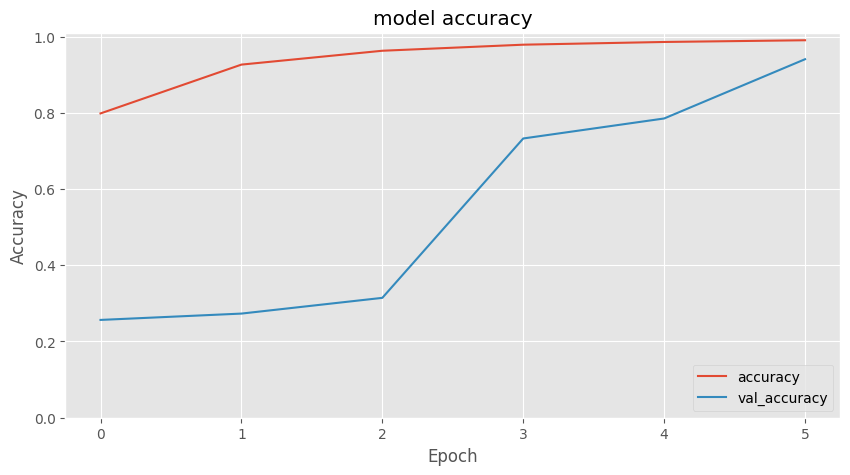

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

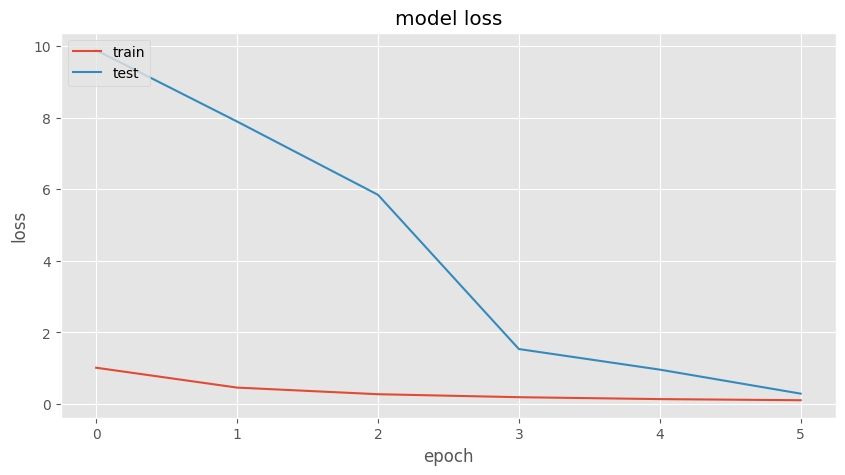

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

98/98 [==============================] - 4s 23ms/step


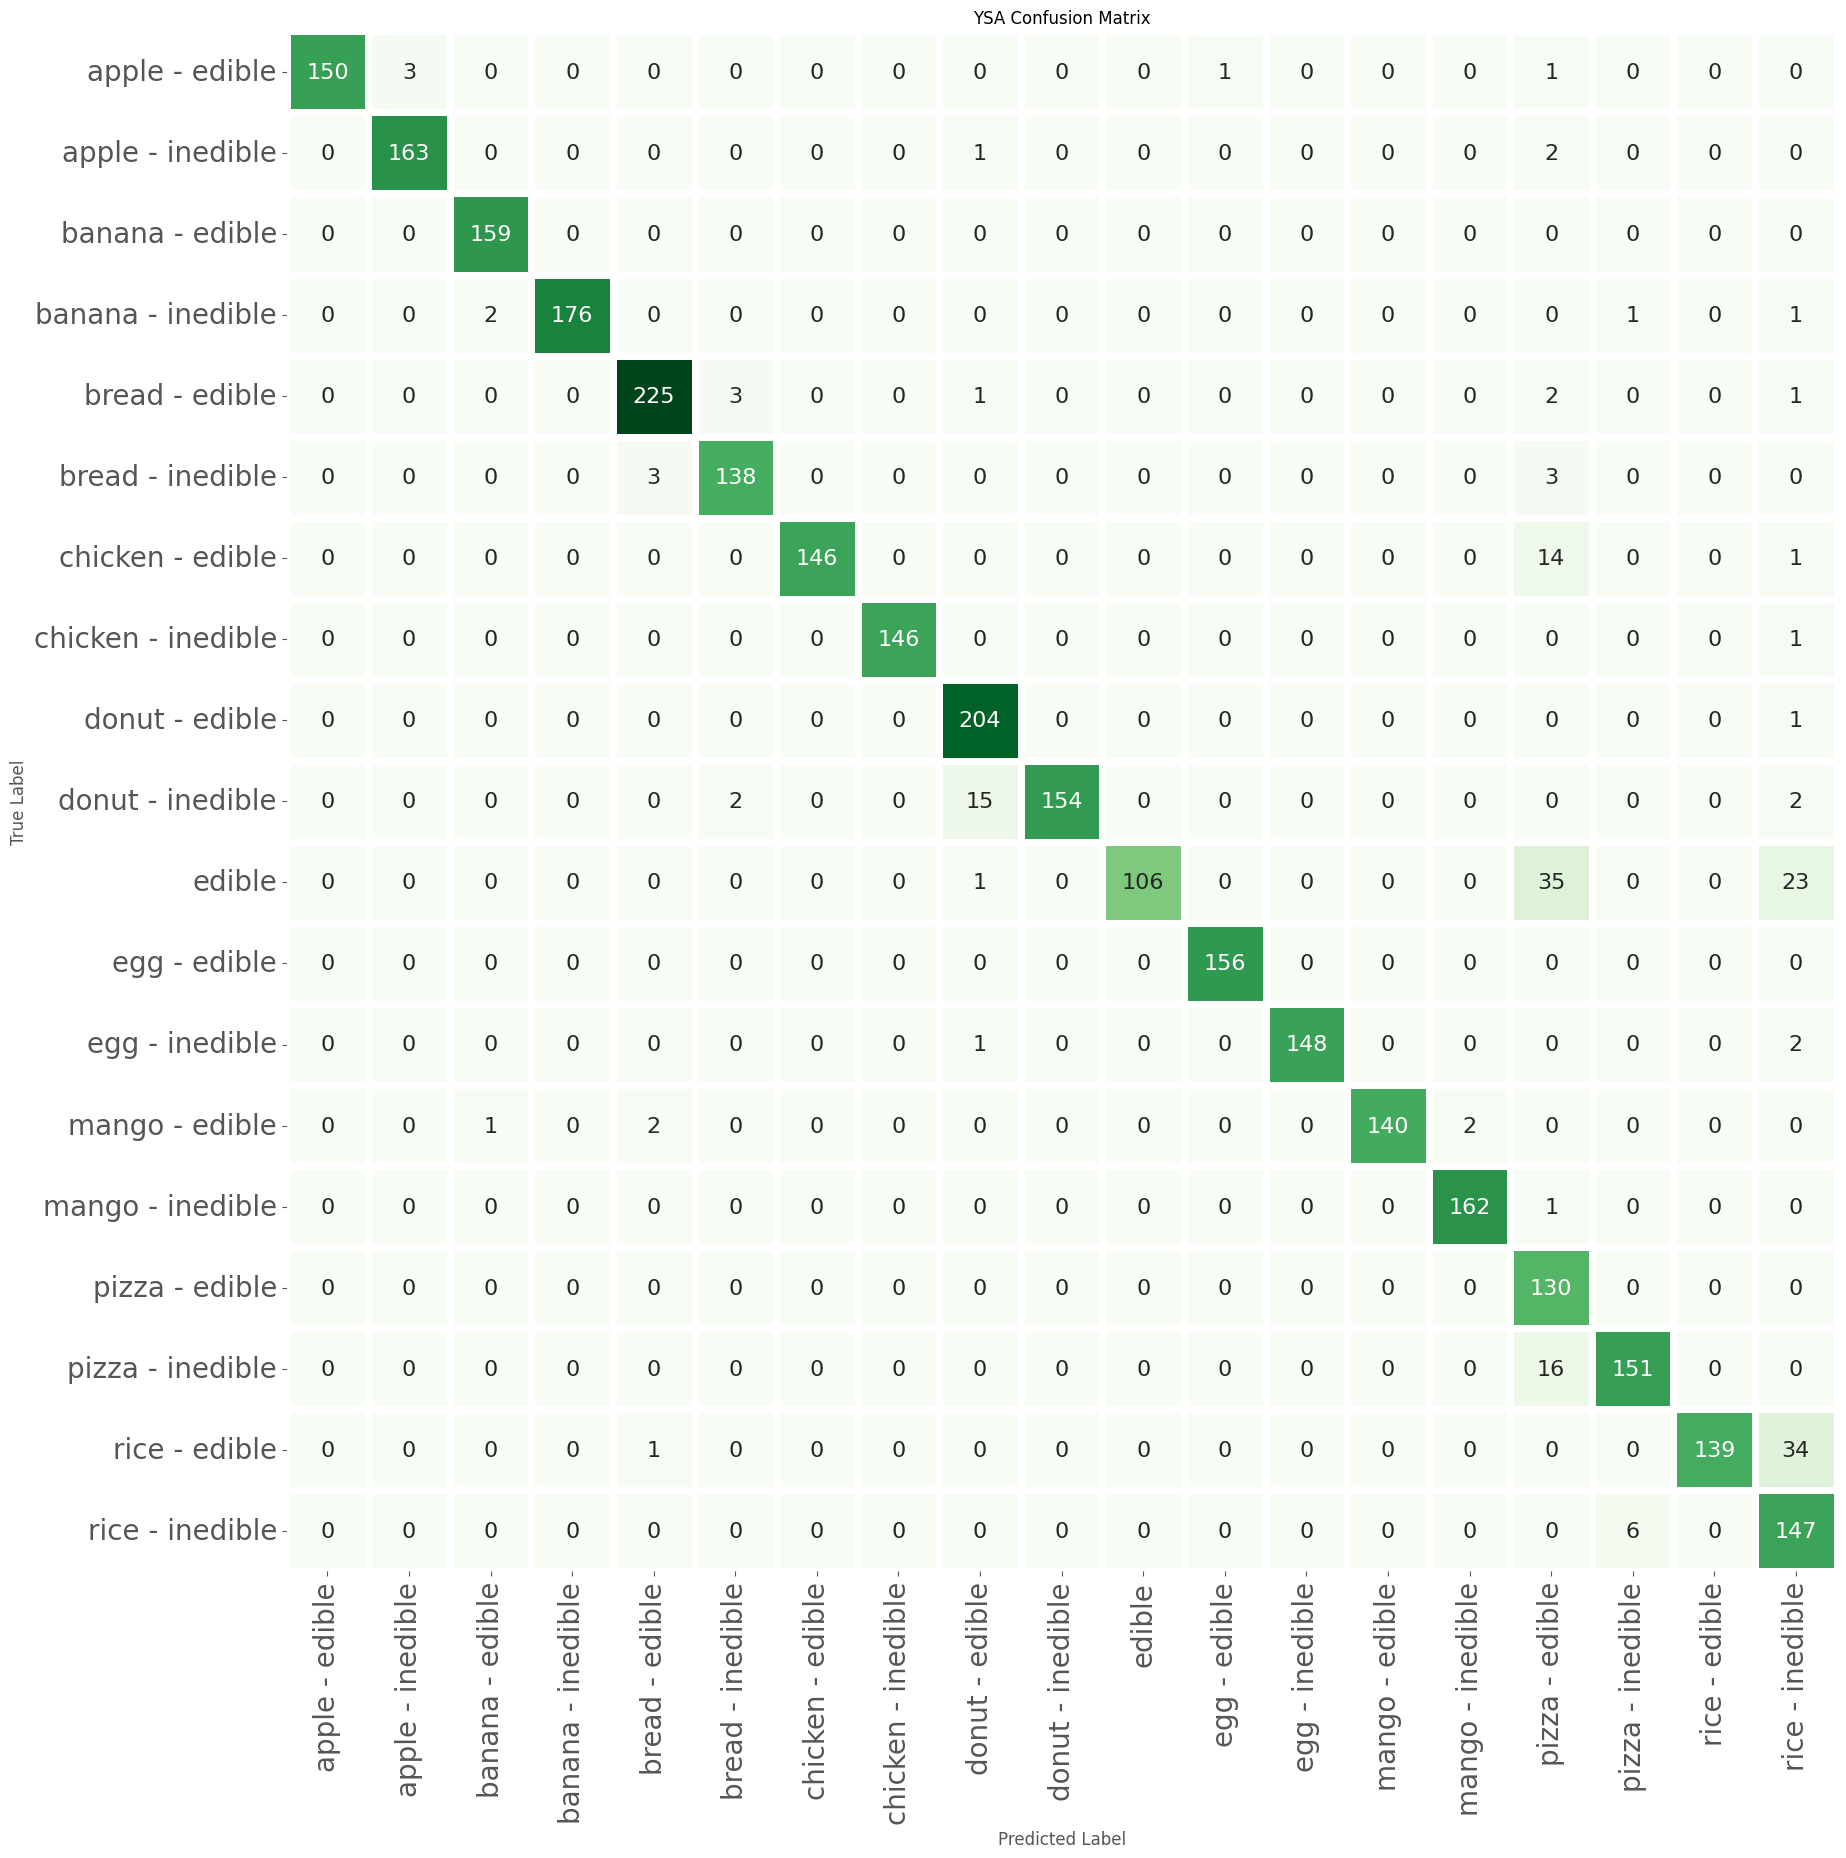

In [21]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=files,
                   index= files, data= cm )

f,ax = plt.subplots(figsize=(20,20))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 20)
plt.yticks(size = 20, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [22]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.951673


In [23]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.941405


In [24]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.940153


In [27]:
def Prediction(test_image):

    global width, height, files, labels

    img = image.img_to_array(test_image)
    img = np.expand_dims(img, axis=0)
    img = img/255.0

    class_list =[
    'apple - edible', 'apple - inedible', 'banana - edible', 'banana - inedible',
    'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible',
    'donut - edible', 'donut - inedible', 'edible', 'egg - edible', 'egg - inedible',
    'mango - edible', 'mango - inedible', 'pizza - edible', 'pizza - inedible', 
    'rice - edible', 'rice - inedible'
]

    pred = model.predict(img)
    predicted_class = class_list[np.argmax(pred[0])]
    return predicted_class

1/1 [==============================] - 0s 119ms/step


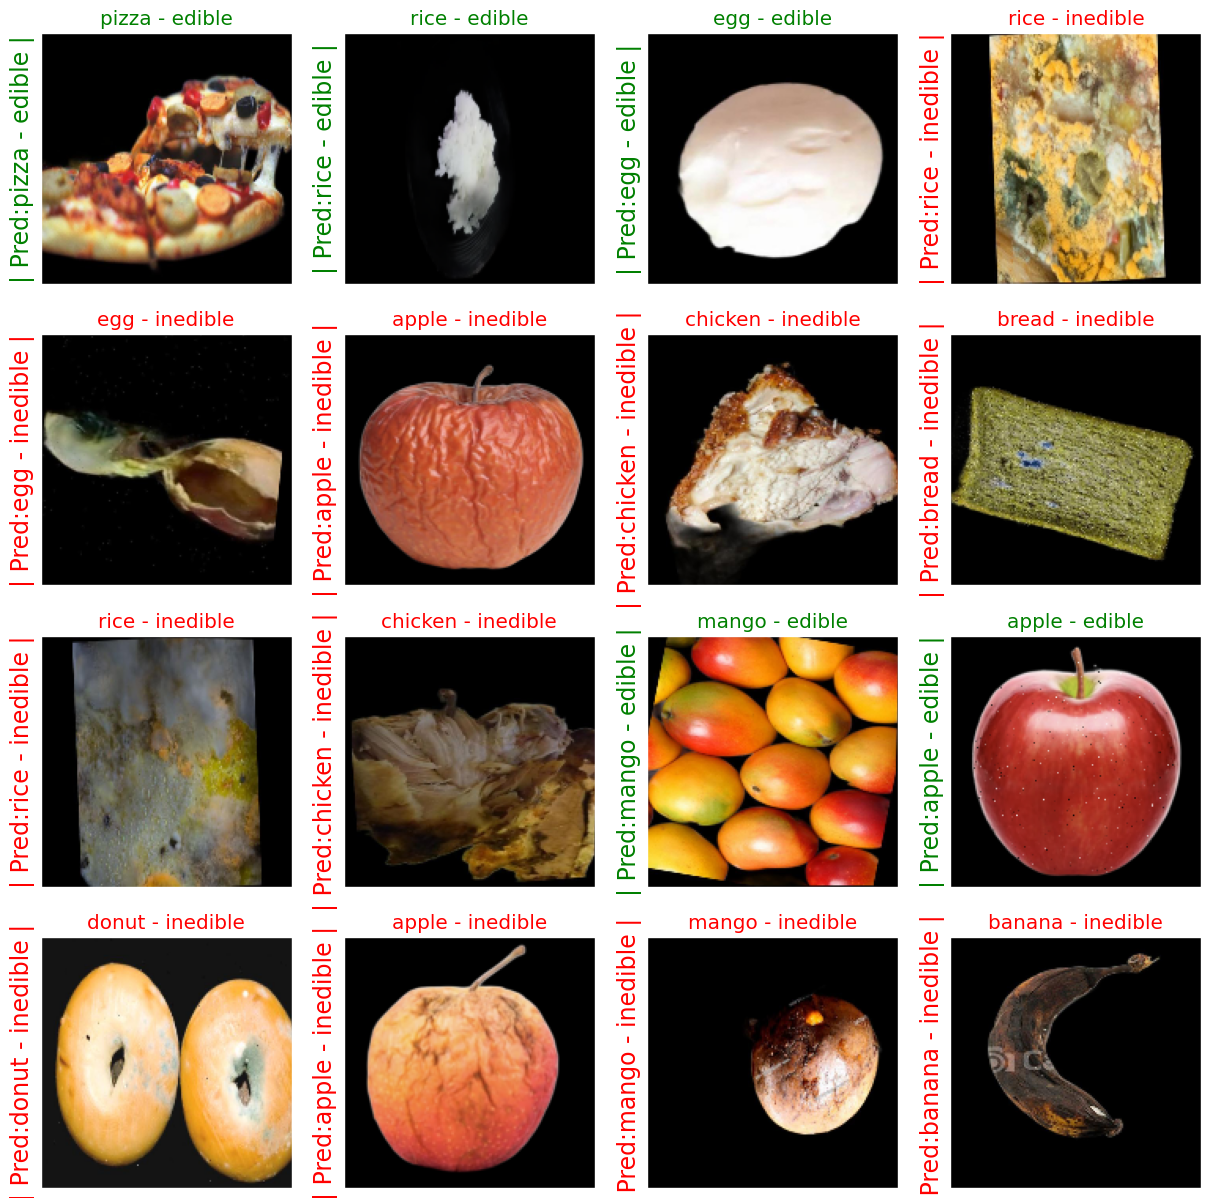

In [28]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if '- edible' in image_target[fig]:
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [30]:
file_path = "/kaggle/input/foodition-test/foodition-test/"
files = os.listdir(file_path)
data = {}

for col in files:
    os.chdir(os.path.join(file_path, col))
    data[col] = [i for i in os.listdir(os.getcwd()) if i.lower().endswith(('.jpg', '.jpeg', '.png'))]

class_list =[
    'apple - edible', 'apple - inedible', 'banana - edible', 'banana - inedible',
    'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible',
    'donut - edible', 'donut - inedible', 'edible', 'egg - edible', 'egg - inedible',
    'mango - edible', 'mango - inedible', 'pizza - edible', 'pizza - inedible', 
    'rice - edible', 'rice - inedible'
]
correct_predictions = 0
total_predictions = 0
incorrect_predictions = []

for col, images in data.items():
    for image_name in images:
        predict_path = os.path.join(file_path, col, image_name)

        img = image.load_img(predict_path, target_size=(160, 160))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalization

        # Assuming `model` is already defined or deployed
        # Perform prediction
        classes = model.predict(x, batch_size=1)

        predicted_class = class_list[np.argmax(classes[0])]
        if ('bener' in col and ' edible' not in predicted_class.lower()) or \
           ('jelek' in col and ' inedible' not in predicted_class.lower()):
            incorrect_predictions.append({
                'image_path': predict_path,
                'actual_class': col,
                'predicted_class': predicted_class
            })
        else: 
            correct_predictions += 1
        total_predictions += 1

print("Incorrect Predictions:")
for prediction in incorrect_predictions:
    print(f"Image: {prediction['image_path']}")
    print(f"Actual Class: {prediction['actual_class']}")
    print(f"Predicted Class: {prediction['predicted_class']}")
    print()
    
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

1/1 [==============================] - 0s 120ms/step
Incorrect Predictions:
Image: /kaggle/input/foodition-test/foodition-test/roti-bener/photo.jpg
Actual Class: roti-bener
Predicted Class: rice - inedible

Image: /kaggle/input/foodition-test/foodition-test/roti-bener/chocolatebread22a.jpg
Actual Class: roti-bener
Predicted Class: rice - inedible

Image: /kaggle/input/foodition-test/foodition-test/donat-bener/download (5).jpeg
Actual Class: donat-bener
Predicted Class: donut - inedible

Accuracy: 88.00%


In [31]:
model.save('/kaggle/working/edible_food_classification_v10.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
